In this notebook we implement the variational quantum eigensolver for systematically finding the low energy subspace comprised of the ground state and the 1st excited state, for the __disordered three site fermionic model with onsite interaction__, (here $t_{ij}$ are chosen from a __uniform random distribution__).
\begin{align}
H=\sum_{ij,\sigma=\uparrow/\downarrow}t_{ij}(c^{\dagger}_{i\sigma}c_{j\sigma}+h.c.)+U\sum_{i}\hat{n}_{i\uparrow}\hat{n}_{i\downarrow}
\end{align}
<figure>
    <img src="./levels.png" alt="drawing" width="300"/>
    <figcaption> &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Fig.1: Lowest 6 energy levels of a four qubit system. The red and green dots marks the ground/1st excited state <figcaption>
<figure>  
<br>




In order to search for the low energy subspace constituting both the ground state(red dot) and the 1st excited state(green dot), we define an appropriate cost function as follows,
\begin{align}
C(\boldsymbol{\theta})&=&\langle\Psi_{1}(\boldsymbol{\theta})|H|\Psi_{1}(\boldsymbol{\theta})\rangle+\langle\Psi_{2}(\boldsymbol{\theta})|H|\Psi_{2}(\boldsymbol{\theta})+\beta|\langle\Psi_{1}(\boldsymbol{\theta})|H|\Psi_{2}(\boldsymbol{\theta})\rangle|^{2}~.
\end{align}



Here $\boldsymbol{\theta}$ are the variational parameters and the states are initialized in orthogonal configurations $\langle\Psi_{2}(0)|\Psi_{1}(0)\rangle=0$ in the beginning of the VQE procedure. We impose a further restriction on the choice of initial states, i.e. there is initially no off-diagonal element in the Hamiltonian that couples them,
\begin{align}
$\langle\Psi_{2}(0)|H|\Psi_{1}(0)\rangle=0.$ 
\end{align}
Then a optimized circuit
\begin{align}
U(\boldsymbol{\theta})=\prod_{k=1}\exp(\tau_{k}\theta_{k})
\end{align}
is sought, that would map these two orthogonal states $|\Psi_{1}(\boldsymbol{\theta})\rangle=U(\boldsymbol{\theta})|\Psi_{1}(0)\rangle$, $|\Psi_{2}(\boldsymbol{\theta})\rangle=U(\boldsymbol{\theta})|\Psi_{2}(0)\rangle$, to the ground state and 1st excited state. The evolution of the  effective low energy Hamiltonian, can be understood as follows:\\
If,
\begin{align}
H_{eff}&=&\begin{pmatrix}\langle\Psi_{1}(\boldsymbol{\theta})|H|\Psi_{1}(\boldsymbol{\theta})\rangle && \langle\Psi_{1}(\boldsymbol{\theta})|H|\Psi_{2}(\boldsymbol{\theta})\rangle\\
\langle\Psi_{2}(\boldsymbol{\theta})|H|\Psi_{1}(\boldsymbol{\theta})\rangle && \langle\Psi_{2}(\boldsymbol{\theta})|H|\Psi_{2}(\boldsymbol{\theta})\rangle
\end{pmatrix}
\end{align}
then the variational optimization happens in the background of a penalty hyper parameter $\beta$, such that the off-diagonal elements is vanishingly small, 
\begin{align}
|\langle\Psi_{1}(\boldsymbol{\theta})|H|\Psi_{2}(\boldsymbol{\theta})\rangle|\to 0~.
\end{align}
In order to perform the concurrent optimization (i.e. optimization towards the subspace constituting ground state & 1st excited state) we need an additional ancilla qubit that is coupled to two orthogonal initial configuration of the system qubits. One way of preparing such a state, for a system of __four qubits and one ancilla qubit__:
<img src="./new_circ_init.jpg" alt="drawing" width="500"/>

In the figure above a set of ancilla controlled unitary initially prepares one of the system configurations $|\Psi_{1}\rangle$ entangled with the $|1\rangle $ configuration of the ancilla, next the orthogonal system configuration ($|\Psi_{2}\rangle$) is entangled with the $|0\rangle$ configuration of the ancilla.

After preparing the initial state the adaptive VQE algorithm is performed, where multiqubit gates are selected based on the maximum gradient criterion (of the cost function $C(\boldsymbol{\theta}$) added and the cost function ($C(\boldsymbol{\theta})$) optimized using a classical optimizer, in our case BFGS.
    
    
    
__Similarities and differences to the subspace search VQE and the variational quantum deflation algorithm__    
    

In [223]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import numpy
import copy
import qiskit
from qiskit.circuit.library import MCMT
import matplotlib.pyplot as plt
from qiskit.circuit.random import random_circuit
from qiskit.opflow.primitive_ops import PauliSumOp
import ipyparallel as ipp
from qiskit.aqua.operators.legacy import op_converter
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.providers.aer import AerSimulator
from openfermion.linalg import givens_decomposition_square as givensRotns
from qiskit.opflow import I,X,Y,Z,StateFn,AbelianGrouper
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from openfermion.linalg import givens_decomposition_square as givensRotns
from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
from qiskit.quantum_info import Pauli
from openfermion.circuits import slater_determinant_preparation_circuit
from qiskit import QuantumCircuit,execute,QuantumRegister,ClassicalRegister
from qiskit import Aer
from joblib import Parallel,delayed
from qiskit.aqua.operators import WeightedPauliOperator,Z2Symmetries
from qiskit.chemistry.components.variational_forms import UCCSD
import scipy
import time
import matplotlib.image as mpllimg
from matplotlib import animation
import numpy
from IPython.display import display, Image
from matplotlib import animation
from IPython.display import HTML

In [224]:
backend=Aer.get_backend('statevector_simulator')

In [225]:
#Construct Model Hamiltonian
def countYgates(pauli_label):
    countYgates = sum(map(lambda x : 1 if 'Y' in x else 0, pauli_label))
    return countYgates
def qubitOp(h1,h2):
    num_qubits=h1.shape[0]
    fer_op=fermionic_op_builder.build_ferm_op_from_ints(h1,h2)
    mapper=ParityMapper()
    qubit_op=mapper.map(fer_op)
    qubit_conv = QubitConverter(mapper, two_qubit_reduction=True, z2symmetry_reduction="auto")
    qubit_op = qubit_conv.convert(fer_op, num_qubits//2)
    return qubit_op
def Hamiltonian(h1=None,h2=None):
    if numpy.any(h1)==None:
        h1=2*numpy.random.rand(num_qubits//2,num_qubits//2)-1
        #impose hermiticity on h1
        h1=(h1+h1.T)/2.
        h1=numpy.block([[h1,numpy.zeros((num_qubits//2,num_qubits//2))],
                       [numpy.zeros((num_qubits//2,num_qubits//2)),h1]])        
    if numpy.any(h2)==None:    
        h2=numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits))
    #impose eight-fold symmetry
        h2[0,0,3,3]=h2[1,1,4,4]=h2[2,2,5,5]=numpy.random.rand()
    qubitH=qubitOp(h1,h2)
    Hmat=qubitH.to_matrix(massive=True)
    w,v=numpy.linalg.eigh(Hmat)
    Eg=w[0]
    Ee=w[1]
    state_g=v[:,0]
    state_e=v[:,1]
    return qubitH,Hmat,Eg,Ee,state_g,state_e,h1,h2

In [226]:
def commutator(A,B):
        B2=WeightedPauliOperator([[-B.paulis[0][0],B.paulis[0][1]]])
        return A.multiply(B).add(B2.multiply(A))
def commutatorPool(qubitH,stripZs=False):
    def stripZ(label):
        label=numpy.array(list(label))
        label[label=='Z']='I'
        label=''.join(list(label))
        return label
    #construct commutator pool from the Hamiltonian
    pool_H=[WeightedPauliOperator([[1j,qubitH.paulis[i][1]]]) for i in range(len(qubitH.paulis))][1:]
    #commutator between operators
    commutator_pool=[WeightedPauliOperator([[1j,commutator(op1,op2).paulis[0][1]]]) for op1 in pool_H for op2 in pool_H if countYgates(commutator(op1,op2).paulis[0][1].to_label())%2!=0]
    labels=[commutator_pool[i].paulis[0][1].to_label() for i in range(len(commutator_pool))]
    unique_labels=numpy.unique(labels)
    if stripZs==True:
        new_labels=[]
        for i in range(len(unique_labels)):
            new_labels.append(stripZ(unique_labels[i]))
        unique_labels=numpy.unique(new_labels)    
    commutator_pool=[WeightedPauliOperator([[1j,Pauli(unique_labels[i])]]) for i in range(len(unique_labels))]
    print(len(commutator_pool))
    return commutator_pool
def compute_gradient(params,gs_ansatz,exc_ansatz,op):
    gs_ansatz.push_hopping_operator(op)
    exc_ansatz.push_hopping_operator(op)
    print(exc_ansatz.num_parameters,gs_ansatz.num_parameters)
    E1=cost_fn(params+[0.01],Hmat,gs_ansatz,exc_ansatz,False)
    E2=cost_fn(params+[-0.01],Hmat,gs_ansatz,exc_ansatz,False)
    grad=(E1-E2)/0.02
    gs_ansatz.pop_hopping_operator()
    exc_ansatz.pop_hopping_operator()
    return grad

#### Modified Cost Fn. for VQE for generating the ground state and 1st excited state
$E=\langle\Psi|H|\Psi\rangle+\langle\Psi'|H|\Psi'\rangle+\beta_{0}|\langle\Psi|\Psi'\rangle|^{2}$ (cost Fn.)

In [227]:
def cost_fn(params,Hmat,gs_ansatz,exc_ansatz,save_steps):
    gs_circ=gs_ansatz.construct_circuit(parameters=params)
    exc_circ=exc_ansatz.construct_circuit(parameters=params)
    gs_state=execute(gs_circ,backend,shots=1024).result().get_statevector() 
    exc_state=execute(exc_circ,backend,shots=1024).result().get_statevector() 
    beta0=1e4
    A=(gs_state.conj()@Hmat@gs_state).real
    B=(exc_state.conj()@Hmat@exc_state).real
    C=((exc_state.conj()@Hmat@gs_state)*(gs_state.conj()@Hmat@exc_state)).real
    E=A+B+beta0*C
    if save_steps==True:
        with open('new_test_4.txt','+a') as f:
            Str=["{:0.16f}".format(params[i].real) for i in range(len(params))]
            print('['+','.join(Str)+']'+'#'+"{:0.16f}".format(A)+'#'+"{:0.16f}".format(B)+'#'+"{:0.05f}".format(C),file=f)
    return E

npj Computational Materials (2021) 7:70 ; https://doi.org/10.1038/s41524-021-00540-

## Cost function for Variational quantum deflation
$E=\langle\Psi|H|\Psi\rangle+\beta_{0}|\langle\Psi_{gs-ansatz}|\Psi\rangle|^{2}$

#### $|\Psi_{gs-ansatz}\rangle$ is the circuit ansatz we generate using adapt VQE

In [228]:
#load Hamiltonian
h1=numpy.load('h1_6.npy')
h2=numpy.load('h2_6.npy')

In [229]:
num_qubits=6
#h1 is a random 4x4 hopping Hamiltonian
qubitH,Hmat,Eg,E1,state_g,state_e,h1,h2=Hamiltonian(h1,h2)

In [230]:
#Hamiltonian is a Tapered Summed Pauli Operator oobtained from parity encoding and two qubit reduction
print(qubitH)

-0.4707452762207464 * IIII
+ 0.1365915752151789 * ZIII
- 0.11309137029690804 * IZII
- 0.16805495419167477 * ZZII
- 0.1365915752151789 * IIZI
- 0.10249643119330751 * ZIZI
+ 0.11309137029690802 * IIIZ
+ (-0.10249643119330751+6.938893903907228e-18j) * IZIZ
- 0.16805495419167477 * IIZZ
+ 0.10249643119330752 * ZZZZ
+ 0.16640421719930132 * XIII
- 0.16640421719930132 * XZII
+ 0.049183861940033304 * IXII
+ (0.049183861940033304+3.469446951953614e-18j) * ZXII
- 0.002902392569130773 * XXII
+ 0.0029023925691307726 * YYII
+ 0.16640421719930132 * IIXI
+ 0.16640421719930132 * IIXZ
+ 0.049183861940033304 * IIIX
- 0.049183861940033304 * IIZX
+ (-0.0029023925691307726-2.168404344971009e-19j) * IIXX
+ 0.0029023925691307726 * IIYY


In [231]:
w,v=numpy.linalg.eigh(Hmat)

In [232]:
w[0],w[1]

(-1.1146860513261823, -1.0666124063177136)

In [233]:
#function added for convenience to map onto weighted pauli operator of qiskit aqua package
def _to_weighted_pauli_operator(Op):
    weighted_op=WeightedPauliOperator([[0,Pauli('I'*(num_qubits-2))]])
    for i in range(len(Op)):
        List=Op[i:i+1].primitive.to_list()
        weighted_op.add(WeightedPauliOperator([[List[0][1],Pauli(List[0][0])]]))
    return weighted_op                   

In [234]:
weighted_H=_to_weighted_pauli_operator(qubitH)

In [235]:
#pool
pool=commutatorPool(weighted_H,stripZs=False)

36


# the function below carries out adapt VQE with a given cost fn.

In [236]:
def build_parametrized_ansatz(init_circ,generators):
    var_form_base=UCCSD(num_qubits,num_particles=num_qubits//2, initial_state=init_circ,qubit_mapping='parity',two_qubit_reduction=True)
    var_form_base.manage_hopping_operators()
    for i in range(len(generators)):
        var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli(generators[i])]]))
    return var_form_base    

In [237]:
#build parametrized circuit for gs from the data_file
circ=QuantumCircuit(4)
circ.x(0)
circ.x(2)
circ.ry(-numpy.pi/3,2)
var_form_base=build_parametrized_ansatz(circ,[])
circ1=QuantumCircuit(4)
circ1.x(1)
circ1.x(3)
circ.ry(-numpy.pi/3,3)
var_form_base2=build_parametrized_ansatz(circ1,[])

OSError: [Errno 12] Cannot allocate memory

In [238]:
# with open('new_test_2.txt','r') as f:
#     lines=f.readlines()
#     Labels=[]
#     Energy1=[]
#     Energy2=[]
#     for i in range(len(lines)):
#         if lines[i][0]=='l':
#             Labels.append(lines[i].split('-')[1][1:-1])
#         else:
#             Energy1.append(eval(lines[i].split('#')[1]))
#             Energy2.append(eval(lines[i].split('#')[2]))
#     params=eval(lines[-1].split('#')[0])        

In [239]:
# params_new=numpy.array(params)+(2*numpy.random.rand(len(params))-1)*0.03

In [240]:
# for i in range(len(Labels)):
#     var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli(Labels[i])]]))
#     var_form_base2.push_hopping_operator(WeightedPauliOperator([[1j,Pauli(Labels[i])]]))

In [241]:
gs_circ=var_form_base.construct_circuit(parameters=[])
exc_circ=var_form_base2.construct_circuit(parameters=[])

In [242]:
gs_state=execute(gs_circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector() 
exc_state=execute(exc_circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()
gs_state.conj()@Hmat@gs_state,exc_state.conj()@Hmat@exc_state,gs_state.conj()@Hmat@exc_state

((-0.6124872934480732+4.9717615506907746e-18j),
 (-0.2371317990307043+6.938893903907228e-18j),
 5.4210108624275204e-20j)

In [243]:
gs_state@exc_state.conj()

0j

In [244]:
def adapt_vqe(cost_fn,Hmat,pool,gs_ansatz,exc_ansatz,steps,params):
    EnergyArr=[]
    ExcOps=[]
    ti=time.time()
    for i in range(steps):
        grads=numpy.array([compute_gradient(params,gs_ansatz,exc_ansatz,pool[i]) for i in range(len(pool))])#qubit_pool_UCCSD))))#
        indexes=numpy.argsort(abs(grads))[::-1][:5]
        print("five highest grads",grads[indexes[0]],grads[indexes[1]],grads[indexes[2]],grads[indexes[3]],grads[indexes[4]])
        if ((i>=1) and (pool[indexes[0]].paulis[0][1].to_label()==ExcOps[-1])):
            chosen_id=indexes[1]
        elif ((i>=2) and (pool[indexes[0]].paulis[0][1].to_label()==ExcOps[-2])):
            chosen_id=indexes[2]
        elif ((i>=3) and (pool[indexes[0]].paulis[0][1].to_label()==ExcOps[-3])):
            chosen_id=indexes[3]
        elif ((i>=4) and (pool[indexes[0]].paulis[0][1].to_label()==ExcOps[-4])):
            chosen_id=indexes[4]
        else:
            chosen_id=indexes[0]
        PauliOp=pool[chosen_id]
        ExcOps.append(PauliOp.paulis[0][1].to_label())
        print("chosen Op",ExcOps[-1])
        with open('new_test_4.txt','a') as f:
            print("label-",ExcOps[-1],file=f)
        params.append(0.0)
        gs_ansatz.push_hopping_operator(PauliOp)
        exc_ansatz.push_hopping_operator(PauliOp)
        res=scipy.optimize.minimize(cost_fn,params,args=(Hmat,gs_ansatz,exc_ansatz,True),method='BFGS',options={'ftol':1e-7})
        params,E=list(res['x']),res['fun']
        print("num_params",var_form_base.num_parameters)
        print("Energy",E)
        EnergyArr.append(E)
        print("time elapsed",time.time()-ti)    
        error=EnergyArr[-1]-Eg

In [245]:
#This qubit-adapt VQE functionality leads to the ground state below
adapt_vqe(cost_fn,Hmat,pool,var_form_base,var_form_base2,25,[])

1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
five highest grads -0.7426657274601678 -0.7426657274601678 0.7426657274601567 -0.6655011269263211 0.6655011269263211
chosen Op YZZI


KeyboardInterrupt: 

In [246]:
%matplotlib inline

In [247]:
def energy_level(p,q):
    figure,ax=plt.subplots(1,figsize=(4,6))
    w,v=numpy.linalg.eigh(Hmat)
    ax.plot([0]*9,w[:9],marker='_',markersize=40,linestyle='',markeredgewidth=2.5)
    ax.set_ylabel('Energy',fontsize=15)
    ax.set_xlabel('')
    ax.set_xlim([-0.1,0.1])
    ax.set(xticklabels='')
    ax.set_yticks(numpy.round(w[:9],3))
    ax.tick_params(labelsize=8)
    ax.scatter(0,p,marker='o',color='red',s=120)
    ax.scatter(0,q,marker='o',color='green',s=120)
    plt.savefig('levels.png')
    return ax

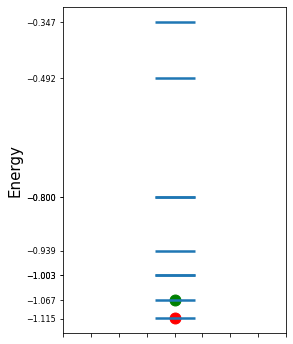

In [248]:
energy_level(w[0],w[1])

In [249]:
w

array([-1.11468605, -1.06661241, -1.0033055 , -1.0033055 , -0.93941072,
       -0.7998046 , -0.7998046 , -0.49202574, -0.34667882, -0.32651197,
       -0.14480605, -0.14317792, -0.08729197, -0.07987101, -0.07987101,
        0.89523944])

In [250]:
labels=[]
params_arr=[]
Eg_arr=[]
E1_arr=[]
count_arr=[]
count=0
with open('new_test_4.txt','r') as f:
    lines=f.readlines()
    for i in range(len(lines)):
        line=lines[i]
        if line[0]=='l':
            label=line.split('-')[1][1:-1]
            labels.append(label)
            count_arr.append(count)
            count=0
        else:
            count=count+1
            params,Eg,E1,C=lines[i].split('#')
            params_arr.append(eval(params))
            Eg_arr.append(eval(Eg))
            E1_arr.append(eval(E1))
    count_arr.append(count)        
#     params,Eg,E1=lines[-1].split('#')
#     params_arr.append(eval(params))
#     Eg_arr.append(eval(Eg))
#     E1_arr.append(eval(E1))                      

In [253]:
def add_multiqubit_gate(pauli_string, param, circuit):
    num_qubits=circuit.num_qubits
    qr=QuantumRegister(num_qubits,'q')
    if pauli_string == 'I'*num_qubits:
        gate = 1
        for j in range(len(pauli_string)):
            gate = numpy.kron(gate, Pauli('I').to_matrix())
        gate *= -1j * np.sin(param)
        gate += numpy.cos(param) * np.eye(2**num_qubits)
        circuit.unitary(gate, qr, label=pauli_string)
    else:
        qubits_to_act_on = []
        gate = 1
        for j in range(len(pauli_string)):
            if pauli_string[j] != 'I':
                gate=numpy.kron(Pauli(pauli_string[j]).to_matrix(),gate)
                qubits_to_act_on.append(num_qubits-j-1)
        gate *= (-1j * numpy.sin(param))
        gate += numpy.cos(param) * numpy.eye(2**len(qubits_to_act_on))
        List_regs=[qr[i] for i in qubits_to_act_on][::-1]
        Label=pauli_string+"\n{:0.02f}".format(param.real)
        circuit.unitary(gate, List_regs, label = Label)
    return circuit

In [254]:
inds=[0,5,9,11]+[16,29,35,39]+[40,70,90,114]+[115,150,200,250,280]+[281,312,375,406]+[407,450,500,550,598]+[600,720,740]+[741,1200,1500,1592]+[1593,1650,1700,1750,2001]+list(numpy.linspace(2002,24682,71))

In [255]:
len(inds)

109

In [256]:
# First set up the figure, the axis, and the plot element we want to animate
#indexes=list(numpy.arange(3,10))+list(numpy.arange(10,37))+list(numpy.arange(75,85))+list(numpy.arange(140,146))
def init_circ():
    qr=QuantumRegister(5,'q')
    circ=QuantumCircuit(qr)
    circ.h(4)
    circ.cx(4,qr[0])
    circ.cx(4,qr[2])
    circ.cry(-numpy.pi/3,4,qr[2])
    circ.x(4)
    circ.cx(4,qr[1])
    circ.cx(4,qr[3])
    circ.cry(-numpy.pi/3,4,qr[3])
    return circ
fig,ax = plt.subplots(2,1,figsize=(14,12))
#ax.plot([0,0,0,0],w,marker='_',markersize=40,linestyle='',markeredgewidth=5)
ax[0].set_ylabel('Energy',fontsize=15)
ax[0].set_xlabel('steps',fontsize=15)
ax[0].set_xlim([0,2000])
ax[0].set_ylim([-1.2,0.1])
ax[0].set_yticks([-1.2,-0.9,-0.6,-0.3])
ax[0].tick_params(labelsize=15)
#ax[0].set_yscale('log')
line_plt1,=ax[0].plot([],[],color='red',markersize=10,linestyle='-',label='1st excited_state')
line_plt2,=ax[0].plot([],[],color='green',markersize=10,linestyle='-',label='ground_state')
scatter_plt1,=ax[0].plot([],[],marker='o',color='red',markersize=10,linestyle='-')
scatter_plt2,=ax[0].plot([],[],marker='o',color='green',markersize=10,linestyle='-')
circ=init_circ()
circ.draw('mpl',filename='./new_circ_init.jpg',scale=2.5)
#ax[1].axis("off")
ax[1].axis("off")
# img1=mpllimg.imread('./levels.png')
# image1=ax[1].imshow(img1)
img=mpllimg.imread('./new_circ_init.jpg')
image=ax[1].imshow(img)


def prepare_circ(params):
    circ=QuantumCircuit(QuantumRegister(5,'q'))
    circ.h(4)
    circ.cx(4,0)
    circ.cx(4,2)
    circ.cry(-numpy.pi/3,4,2)
    circ.x(4)
    circ.cx(4,1)
    circ.cx(4,3)
    circ.cry(-numpy.pi/3,4,3)
    for j in range(len(params)):
        circ=add_multiqubit_gate(labels[j], params[j], circ)
    return circ
# Initialization function: plot the background of each frame
def init():
    line_plt1.set_data([],[])
    line_plt2.set_data([],[])
    scatter_plt1.set_data([],[])
    scatter_plt2.set_data([],[])
    img=mpllimg.imread('./circ_init.jpg')
    ax[1].axis("off")
    image=ax[1].imshow(img)
    return image,line_plt1,line_plt2,scatter_plt1, scatter_plt2

# # Animation function which updates figure data.  This is called sequentially
def animate(i):
    if inds[i]>2000:
        ax[0].set_ylim([-1.02,-1.12])
        minor_loc=FixedLocator(numpy.round(w[0:3],2))
        ax[0].yaxis.set_minor_locator(minor_loc)
        
    ax[0].set_xlim([0,inds[i]+20])
    line_plt1.set_data(numpy.arange(inds[i]),Eg_arr[:int(inds[i])])
    line_plt2.set_data(numpy.arange(inds[i]),E1_arr[:int(inds[i])])
    scatter_plt1.set_data(inds[i],Eg_arr[int(inds[i])])
    scatter_plt2.set_data(inds[i],E1_arr[int(inds[i])])
    circ=prepare_circ(params_arr[int(inds[i])])
    circ.draw('mpl',filename='./circ_instant_new.jpg',scale=2.5)
    img=mpllimg.imread('./circ_instant_new.jpg')
    ax[1].axis("off")
    image=ax[1].imshow(img)
    print(i)
    return line_plt1,line_plt2,scatter_plt1, scatter_plt2,image

# Call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(inds), interval=300, blit=True)

plt.close(anim._fig)

# Call function to display the animation
HTML(anim.to_html5_video())
#anim.save('filename.gif', writer='ffmpeg')

OSError: [Errno 12] Cannot allocate memory

In [118]:
inds

[0,
 5,
 9,
 11,
 16,
 29,
 35,
 39,
 40,
 70,
 90,
 114,
 115,
 150,
 200,
 250,
 280,
 281,
 312,
 375,
 406,
 407,
 450,
 500,
 550,
 598,
 600,
 720,
 740,
 741,
 1200,
 1500,
 1592,
 1593,
 1650,
 1700,
 1750,
 2001,
 2002.0,
 2254.0,
 2506.0,
 2758.0,
 3010.0,
 3262.0,
 3514.0,
 3766.0,
 4018.0,
 4270.0,
 4522.0,
 4774.0,
 5026.0,
 5278.0,
 5530.0,
 5782.0,
 6034.0,
 6286.0,
 6538.0,
 6790.0,
 7042.0,
 7294.0,
 7546.0,
 7798.0,
 8050.0,
 8302.0,
 8554.0,
 8806.0,
 9058.0,
 9310.0,
 9562.0,
 9814.0,
 10066.0,
 10318.0,
 10570.0,
 10822.0,
 11074.0,
 11326.0,
 11578.0,
 11830.0,
 12082.0,
 12334.0,
 12586.0,
 12838.0,
 13090.0,
 13342.0,
 13594.0,
 13846.0,
 14098.0,
 14350.0,
 14602.0,
 14854.0,
 15106.0,
 15358.0,
 15610.0,
 15862.0,
 16114.0,
 16366.0,
 16618.0,
 16870.0,
 17122.0,
 17374.0,
 17626.0,
 17878.0,
 18130.0,
 18382.0,
 18634.0,
 18886.0,
 19138.0,
 19390.0,
 19642.0,
 19894.0,
 20146.0,
 20398.0,
 20650.0,
 20902.0,
 21154.0,
 21406.0,
 21658.0,
 21910.0,
 22162.0,


In [150]:
from matplotlib.ticker import FixedMinorLocator
from matplotlib.ticker import FormatStrFormatter

ImportError: cannot import name 'FixedMinorLocator' from 'matplotlib.ticker' (/home/amukh/Anaconda3-Linux/lib/python3.8/site-packages/matplotlib/ticker.py)

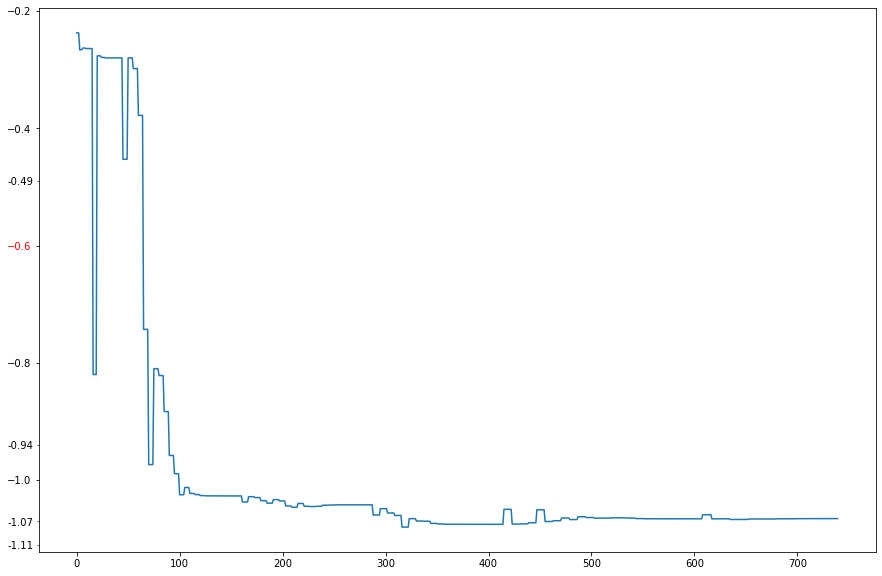

In [158]:
inds=[0,5,9,11]+[16,29,35,39]+[40,70,90,114]+[115,150,200,250,280]+[281,312,375,406]+[407,450,500,550,598]+[600,720,740]
figure,ax=plt.subplots(1,figsize=(15,10))

minor_loc=FixedLocator(numpy.round(w[0:8],2))
ax.yaxis.set_minor_locator(minor_loc)
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.2f"))
ax.get_yticklabels()[3].set_color("red")
ax.plot(numpy.arange(inds[-1]),numpy.array(E1_arr)[:int(inds[-1])])
#ax.plot(numpy.array(Eg_arr)[numpy.array([int(inds[i]) for i in range(len(inds))])])


In [ ]:
minor_loc.ge

In [97]:
numpy.int(numpy.round([0.1,1.1])

AttributeError: 'numpy.ndarray' object has no attribute 'int'

In [100]:
len(E1_arr)

24683

In [138]:
print(minor_loc)